In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import copy

In [2]:
'''
Parameters
'''
radius = 1
res = 40
rho = 6.371e6
R = 1.496e11
alpha = 90/180*np.pi
beta = 60/180*np.pi


sigma = 0.001
nwater = 1.33
epsilon = 0.000000001

day = 17
Ndays = 200
year = Ndays*day
omega_day =  2*np.pi/day 
omega_year = 2*np.pi/year


delta_t = 1
delta_phi = np.pi/res
delta_theta = np.pi/res
delta_Omega = delta_phi*delta_theta 

hours = np.arange(0, day)
time_array = hours.copy()

N_ave = 187

for i in range(1, Ndays):
    time_array = np.append(time_array, hours + i*year/Ndays)

time_res = len(time_array)
print(time_res)

3400


In [37]:
'''
load in Transformation matrix and reflectivity maps

'''
print(alpha,beta)
filename1 = 'NEWTmatrices_res'+str(res)+'_tres'+str(time_res)+'_a'+str(alpha)+'_b'+str(beta)+'.npz'
loaded1 = np.load(filename1)
Tlambv = loaded1['lamb']
Tglintv = loaded1['glint']
Tseelv = loaded1['seel']

filename2 = 'V2Reflectivities_planet'+str(1)+'_res'+str(res)+'.npz'
loaded2  = np.load(filename2)

albedo_map = loaded2['lamb']
onlylamb_map = loaded2['onlylamb']
ocean_map = loaded2['glint']
seeliger_map = loaded2['seel']
albedo_pseudo = loaded2['pseudo']

albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')

print(np.max(Tglintv))

1.5707963267948966 1.0471975511965976
0.05081105753915212


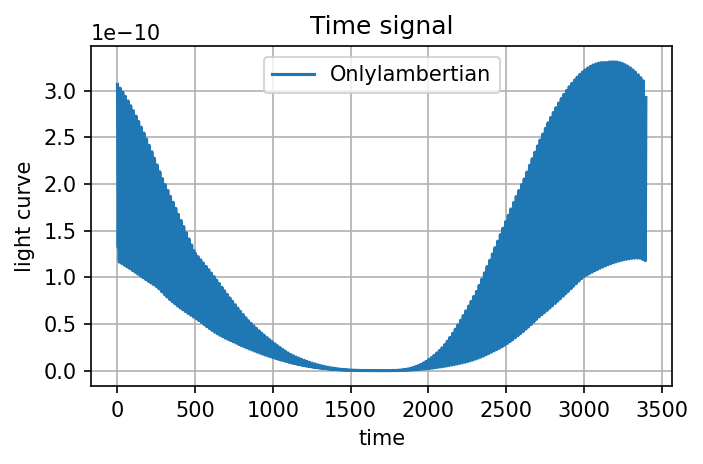

In [25]:
# light is only lambertian


f_onlylamb = np.matmul(Tlambv, onlylamb_map)*rho**2/(R**2)

f_total = f_onlylamb

SVCR = 0.1
f,ax=plt.subplots(figsize=(5,3), dpi=150)
ax.plot(time_array,f_total, '-',label= 'Onlylambertian', alpha = 1)
plt.xlabel('time')
plt.ylabel('light curve')
plt.title('Time signal')
plt.legend()
plt.grid()
plt.show()

In [27]:
# Light is only lambertian


Zeros = np.zeros(2*res*res)
reconstruct_Zeros = Zeros.reshape((res,2*res),order = 'F')

f_real = f_onlylamb
Areallamb = onlylamb_map
Arealglint = np.zeros(2*res*res)
Arealseel = np.zeros(2*res*res)

reconstruct_Areallamb = Areallamb.reshape((res,2*res),order = 'F')
reconstruct_Arealglint = Arealglint.reshape((res,2*res),order = 'F')
reconstruct_Arealseel = Arealseel.reshape((res,2*res),order = 'F')

Tonlylamb = Tlambv 
Tcomp = np.concatenate((Tlambv,Tglintv,Tseelv),axis = 1)

Tonlylamb_pinv = np.linalg.pinv(Tonlylamb, rcond = SVCR)
Tcomp_pinv = np.linalg.pinv(Tcomp, rcond = SVCR)


Aonlylamb = np.matmul(Tonlylamb_pinv, f_real)

lambfactor = 0.8/(np.max(Aonlylamb)-np.min(Aonlylamb))
Aonlylamb_scaled = (Aonlylamb-np.min(Aonlylamb))*lambfactor
reconstruct_Aonlylamb = Aonlylamb_scaled.reshape((res,2*res), order = 'F')


Acomp = np.matmul(Tcomp_pinv, f_real)
Acomplamb = Acomp[:2*res*res]
Acompglint = Acomp[2*res*res:2*2*res*res]
Acompseel = Acomp[2*2*res*res:]

complambfactor = 0.8*0.9/(np.max(Acomplamb)-np.min(Acomplamb))
compglintfactor = 0.1/(np.max(Acompglint)-np.min(Acompglint))
compseelfactor = 0.5*0.4/(np.max(Acompseel)-np.min(Acompseel))

Acomplamb_scaled = (Acomplamb-np.min(Acomplamb))*complambfactor
Acompglint_scaled = (Acompglint-np.min(Acompglint))*compglintfactor
Acompseel_scaled = (Acompseel-np.min(Acompseel))*compseelfactor

reconstruct_Acomplamb = Acomplamb_scaled.reshape((res,2*res), order = 'F')
reconstruct_Acompglint = Acompglint_scaled.reshape((res,2*res), order = 'F')
reconstruct_Acompseel = Acompseel_scaled.reshape((res,2*res), order = 'F')
print(SVCR)

0.1


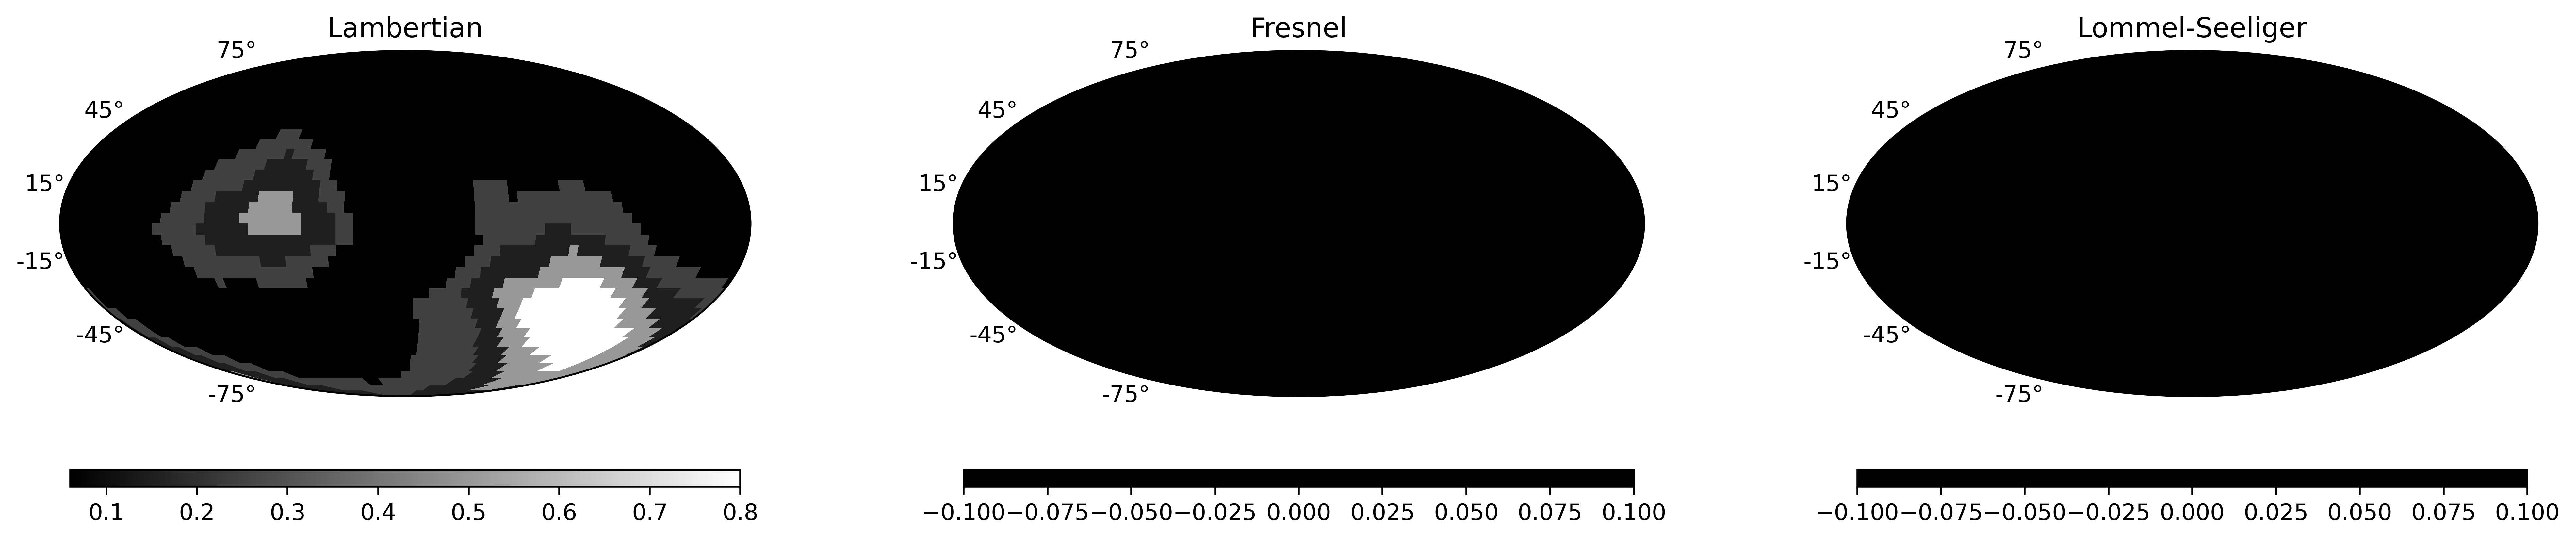

In [28]:
#real signal reconstruction
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('Lambertian')
ax2.title.set_text('Fresnel')
ax3.title.set_text('Lommel-Seeliger')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealglint),cmap = black_cmp)
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealseel),cmap = black_cmp)
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

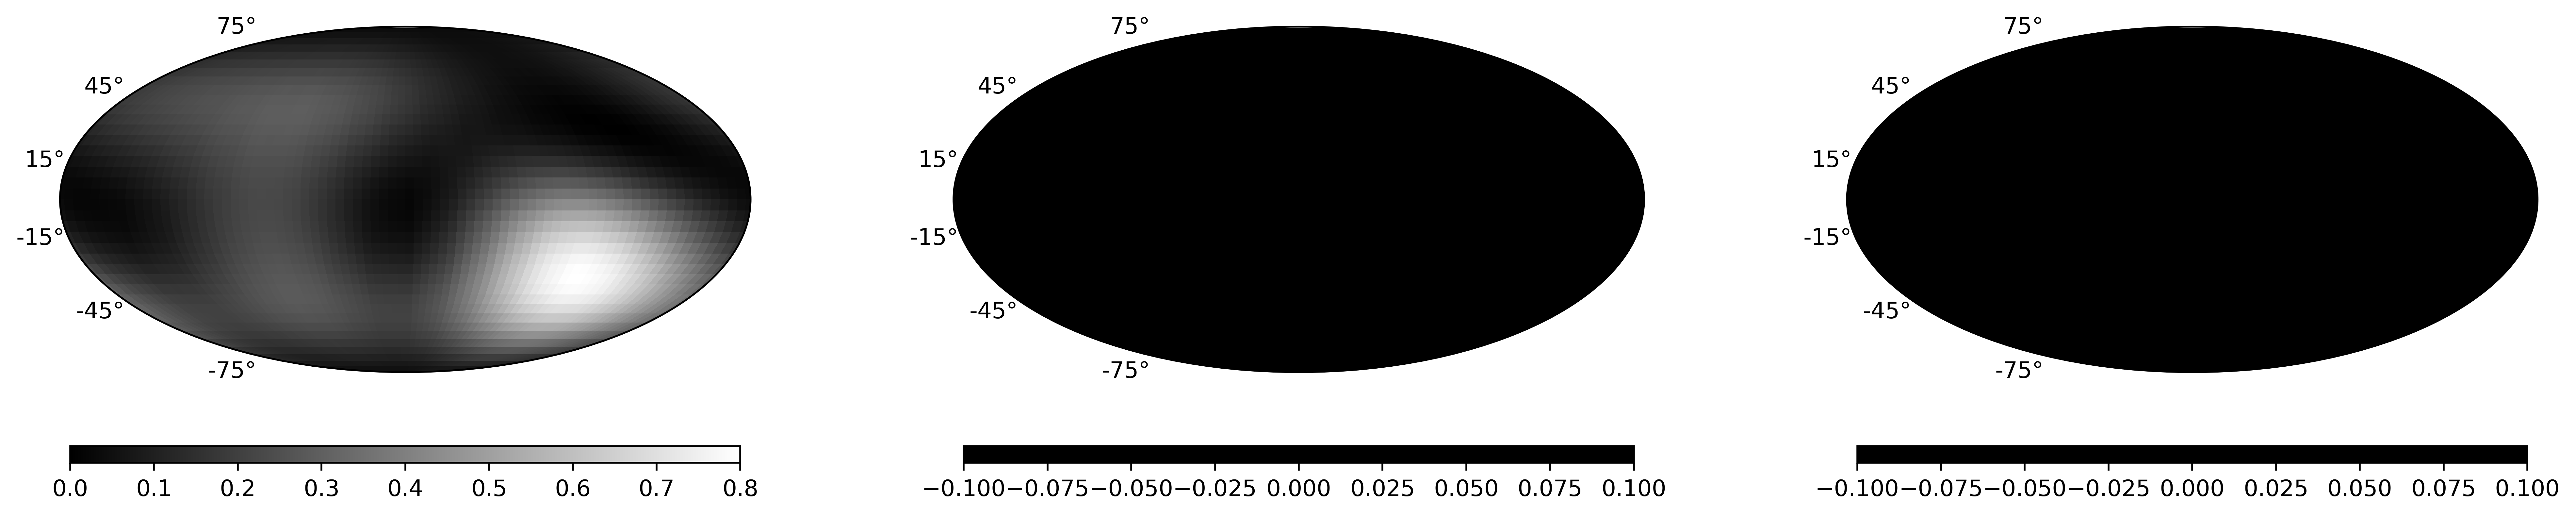

In [29]:
# simple model retrieval
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = black_cmp)
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = black_cmp)
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

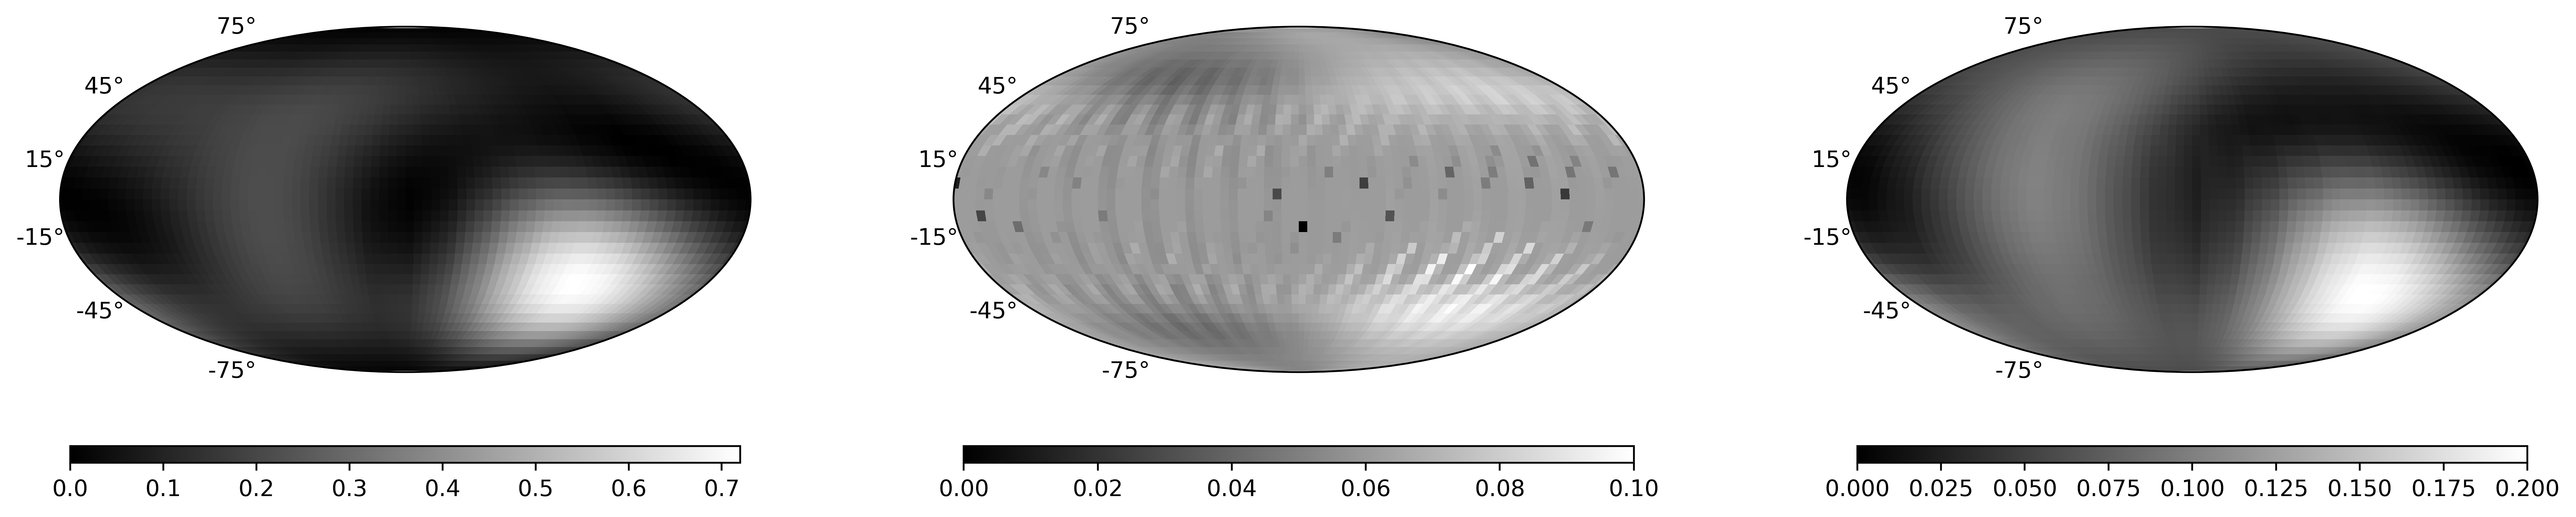

In [30]:
##complex model retrieval
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompglint),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompseel),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

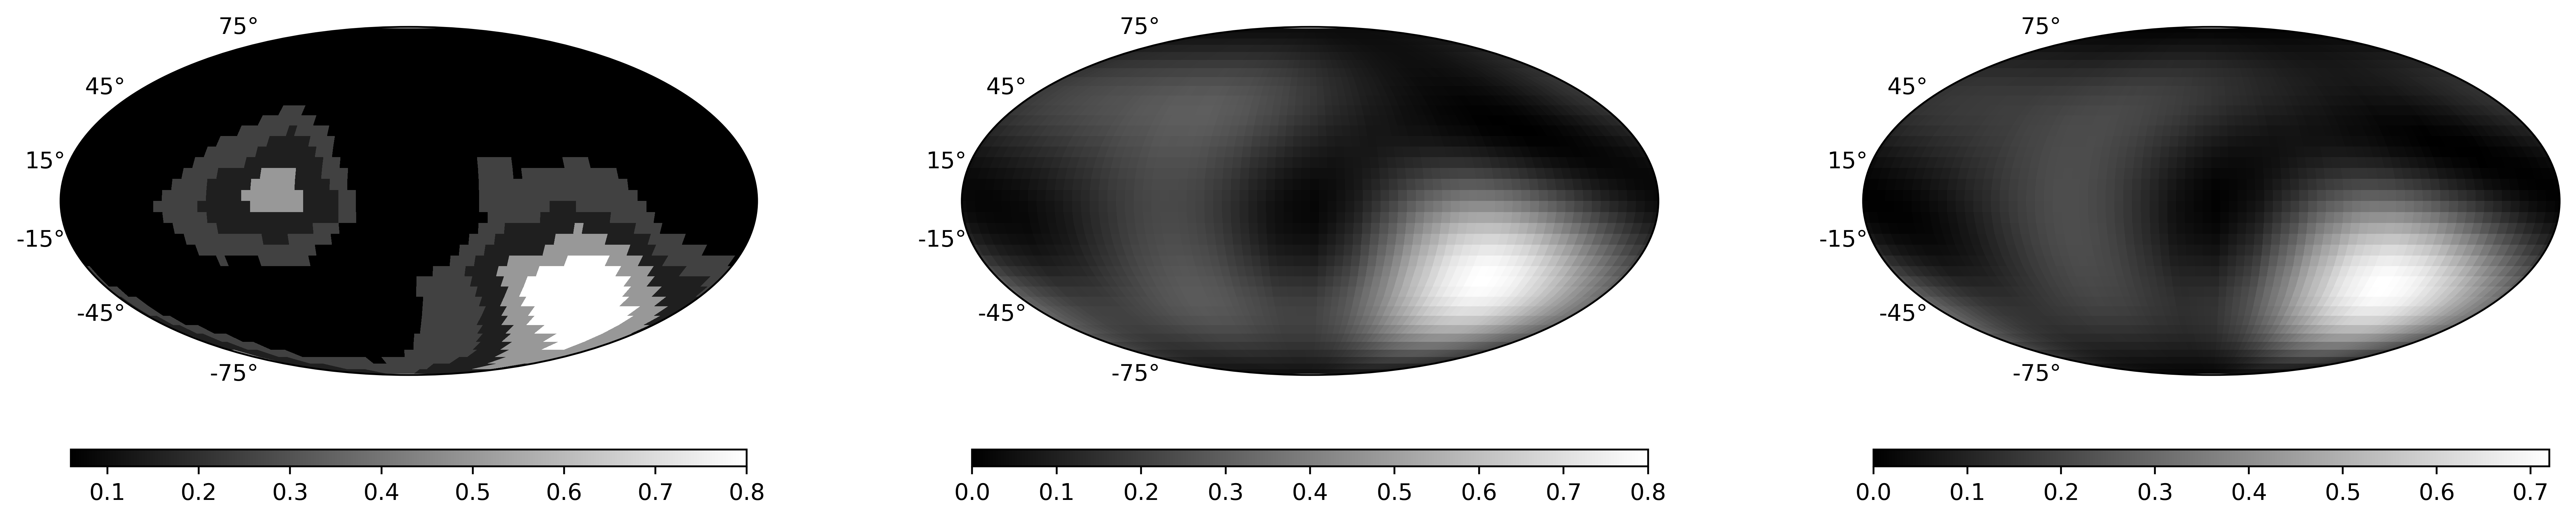

In [31]:
# detailed view of the Lambertian maps

shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')


im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')


     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')
                                                                           
plt.show()

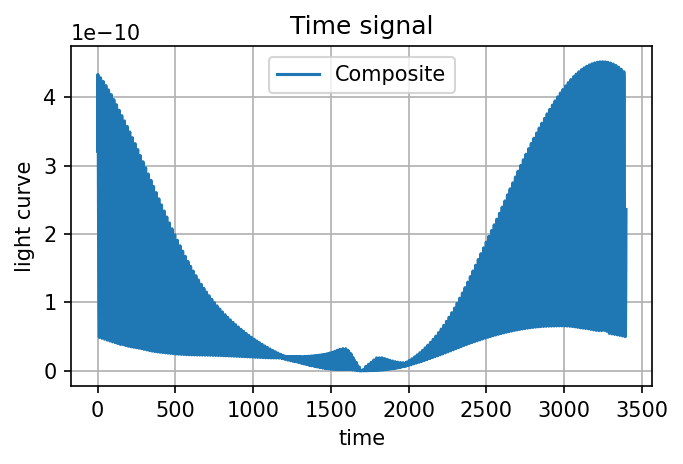

In [45]:
# light is composite


f_onlylamb = np.matmul(Tlambv, onlylamb_map)*rho**2/(R**2)

f_complamb = np.matmul(Tlambv, albedo_map)*rho**2/(R**2)
f_compglint = 2*np.matmul(Tglintv, ocean_map)*rho**2/(R**2)
f_compseel = 2*np.matmul(Tseelv, seeliger_map)*rho**2/(R**2)

f_total = f_complamb+f_compglint+f_compseel

SVCR = 1e-5

f,ax=plt.subplots(figsize=(5,3), dpi=150)
ax.plot(time_array,f_total, '-',label= 'Composite', alpha = 1)
plt.xlabel('time')
plt.ylabel('light curve')
plt.title('Time signal')
plt.legend()
plt.grid()
plt.show()

In [46]:
# Light is composite


Zeros = np.zeros(2*res*res)
reconstruct_Zeros = Zeros.reshape((res,2*res),order = 'F')

f_real = f_total
Areallamb = albedo_map
Arealglint = ocean_map
Arealseel = seeliger_map

reconstruct_Areallamb = Areallamb.reshape((res,2*res),order = 'F')
reconstruct_Arealglint = Arealglint.reshape((res,2*res),order = 'F')
reconstruct_Arealseel = Arealseel.reshape((res,2*res),order = 'F')

Tonlylamb = Tlambv 
Tcomp = np.concatenate((Tlambv,Tglintv,Tseelv),axis = 1)

Tonlylamb_pinv = np.linalg.pinv(Tonlylamb, rcond = SVCR)
Tcomp_pinv = np.linalg.pinv(Tcomp, rcond = SVCR)

Aonlylamb = np.matmul(Tonlylamb_pinv, f_real)
lambfactor = 0.8/(np.max(Aonlylamb)-np.min(Aonlylamb))
Aonlylamb_scaled = (Aonlylamb-np.min(Aonlylamb))*lambfactor
reconstruct_Aonlylamb = Aonlylamb_scaled.reshape((res,2*res), order = 'F')


Acomp = np.matmul(Tcomp_pinv, f_real)
Acomplamb = Acomp[:2*res*res]
Acompglint = Acomp[2*res*res:2*2*res*res]
Acompseel = Acomp[2*2*res*res:]

complambfactor = 0.8*0.9/(np.max(Acomplamb)-np.min(Acomplamb))
compglintfactor = 0.1/(np.max(Acompglint)-np.min(Acompglint))
compseelfactor = 0.5*0.4/(np.max(Acompseel)-np.min(Acompseel))

Acomplamb_scaled = (Acomplamb-np.min(Acomplamb))*complambfactor
Acompglint_scaled = (Acompglint-np.min(Acompglint))*compglintfactor
Acompseel_scaled = (Acompseel-np.min(Acompseel))*compseelfactor

reconstruct_Acomplamb = Acomplamb_scaled.reshape((res,2*res), order = 'F')
reconstruct_Acompglint = Acompglint_scaled.reshape((res,2*res), order = 'F')
reconstruct_Acompseel = Acompseel_scaled.reshape((res,2*res), order = 'F')

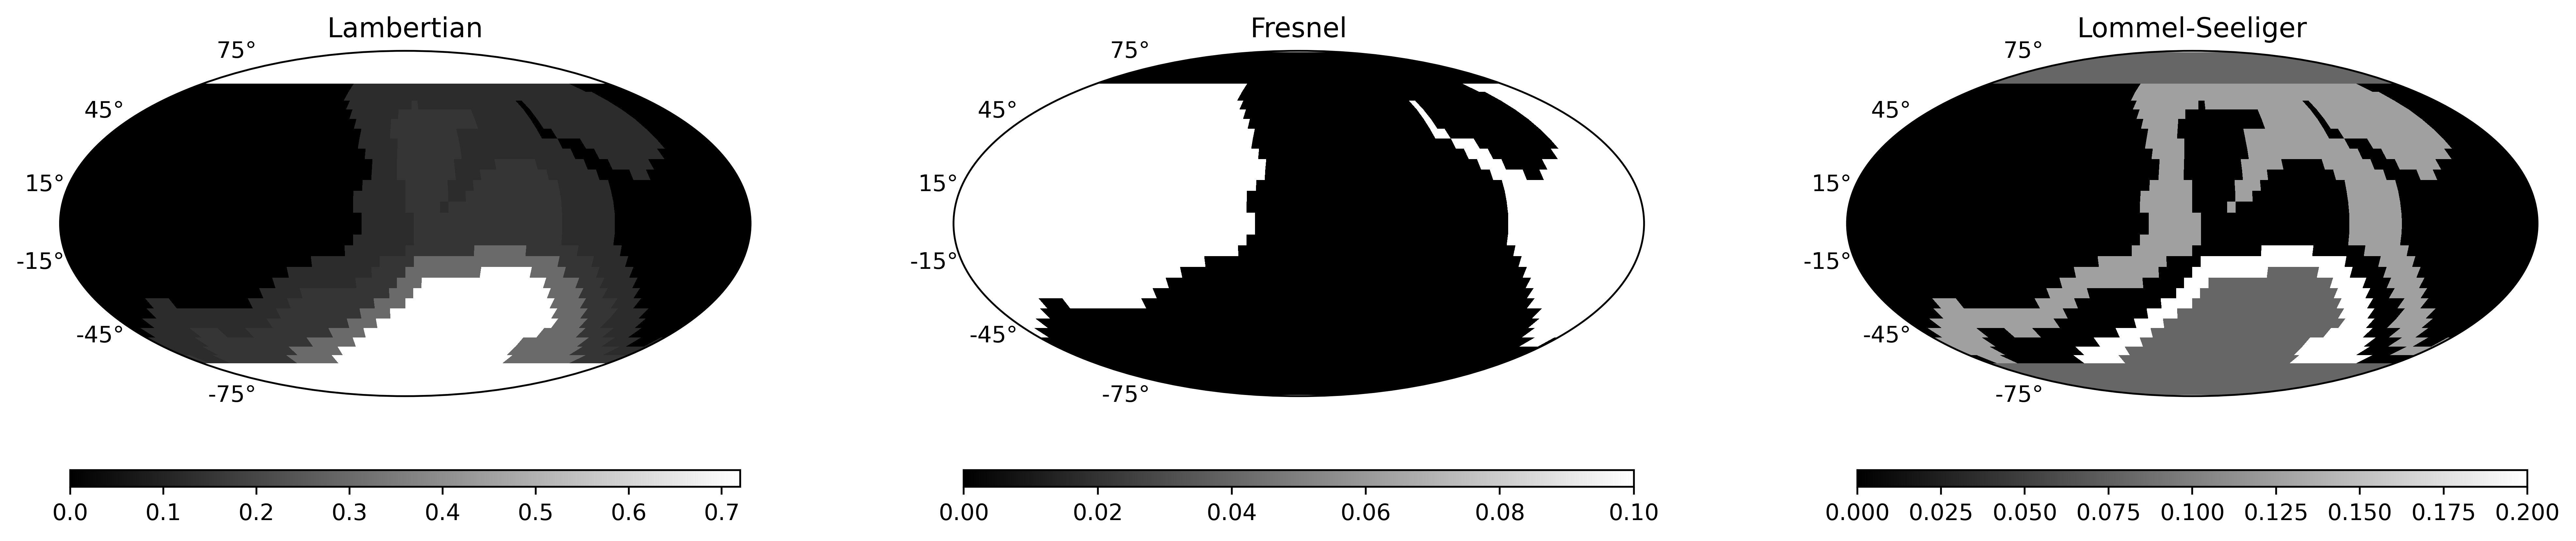

In [47]:
#real signal reconstruction
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('Lambertian')
ax2.title.set_text('Fresnel')
ax3.title.set_text('Lommel-Seeliger')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealglint),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealseel),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

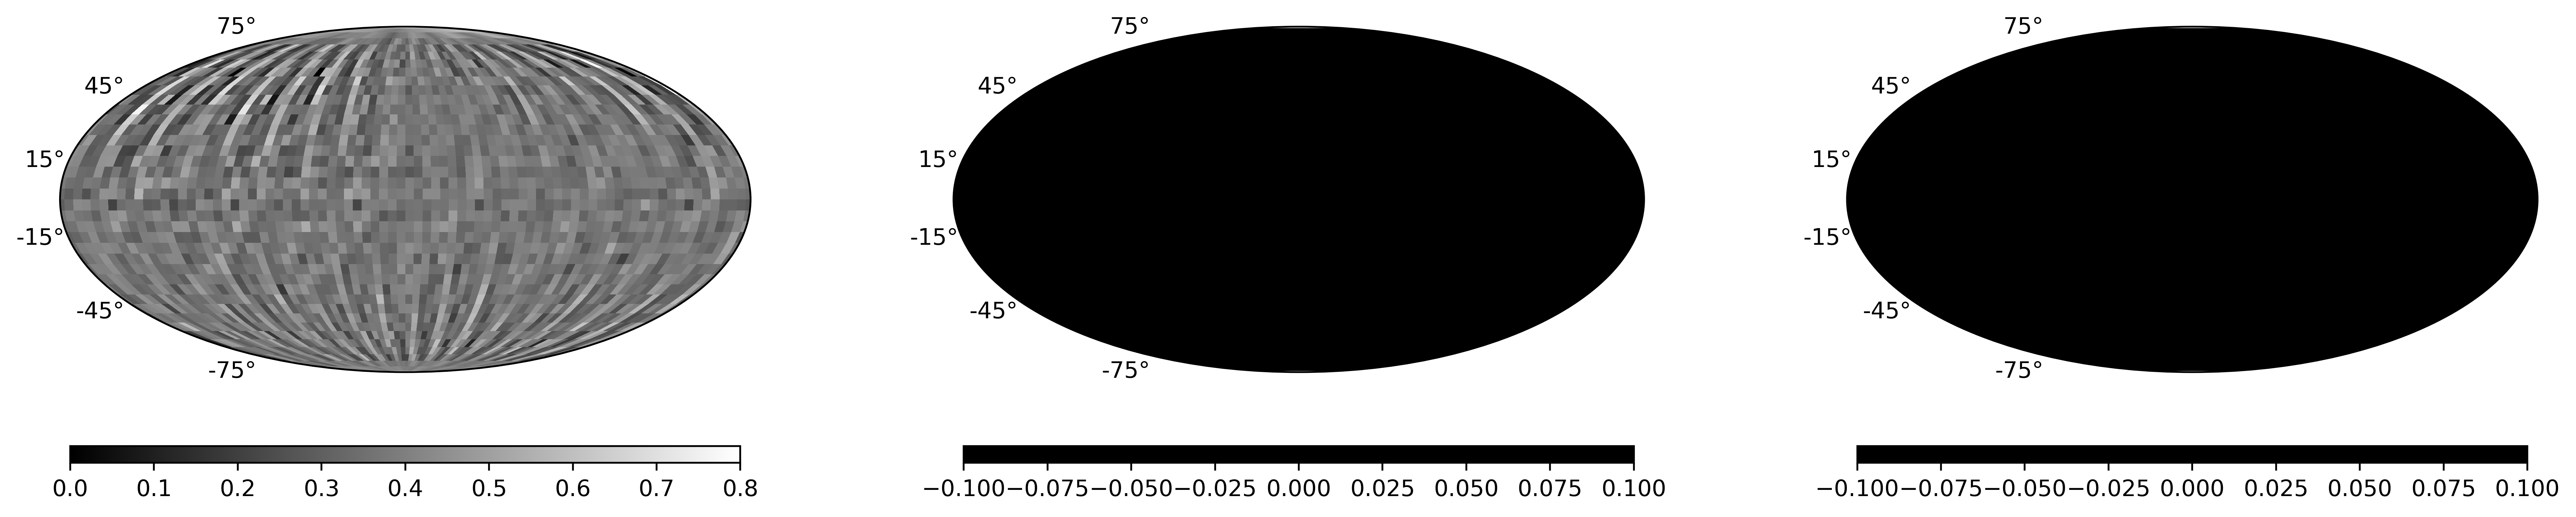

In [48]:
# simple model retrieval
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = black_cmp)
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = black_cmp)
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

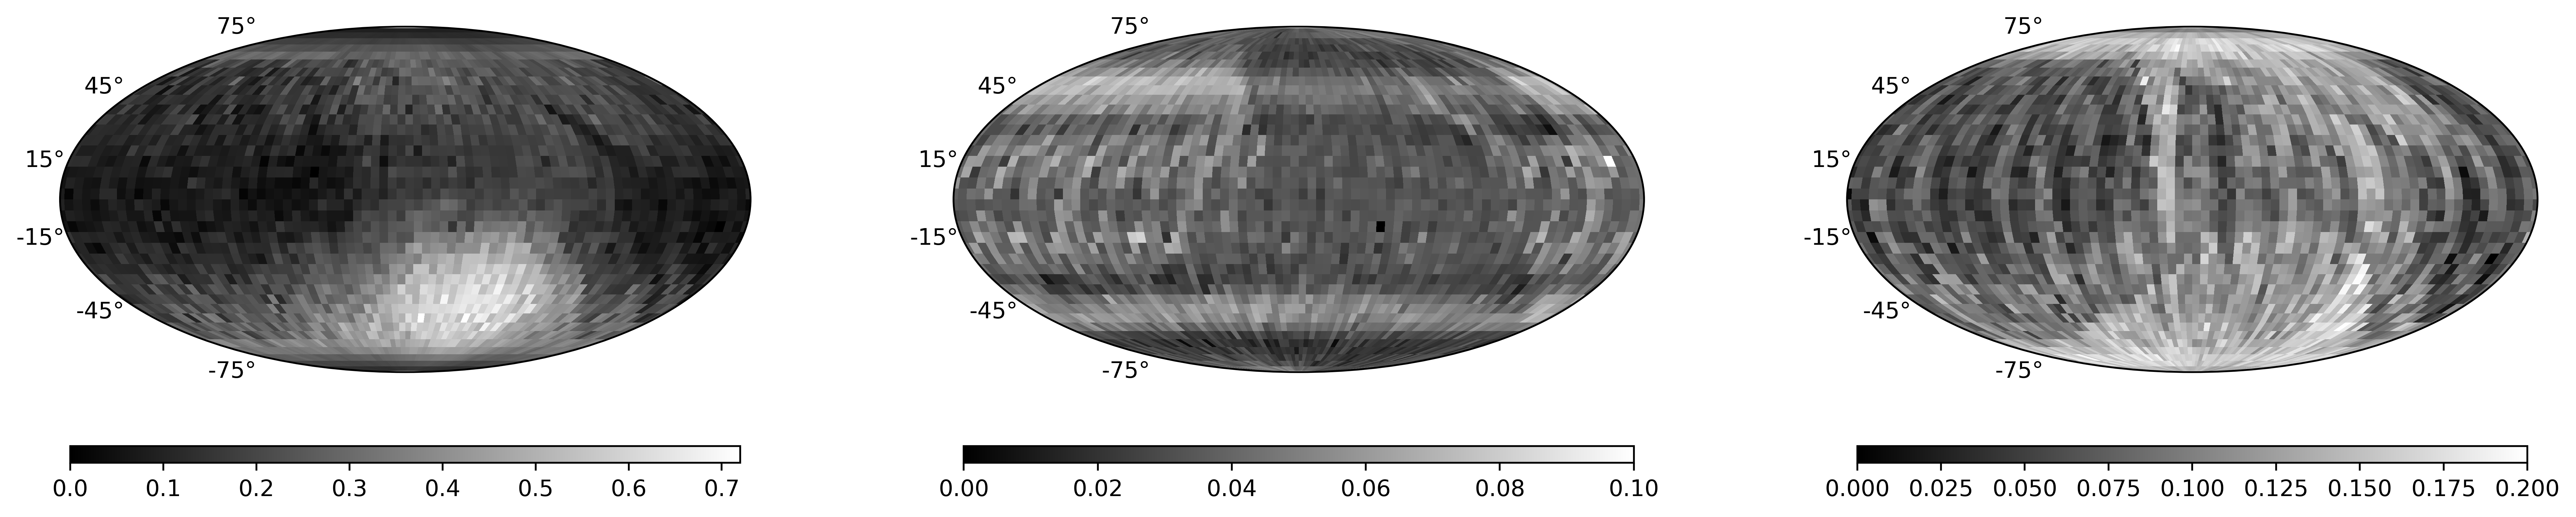

In [49]:
##complex model retrieval
shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

gray = cm.get_cmap('gray',4096)
black = np.vstack((gray(np.linspace(0,0,1))))
black_cmp = ListedColormap(black)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompglint),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompseel),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')

plt.show()

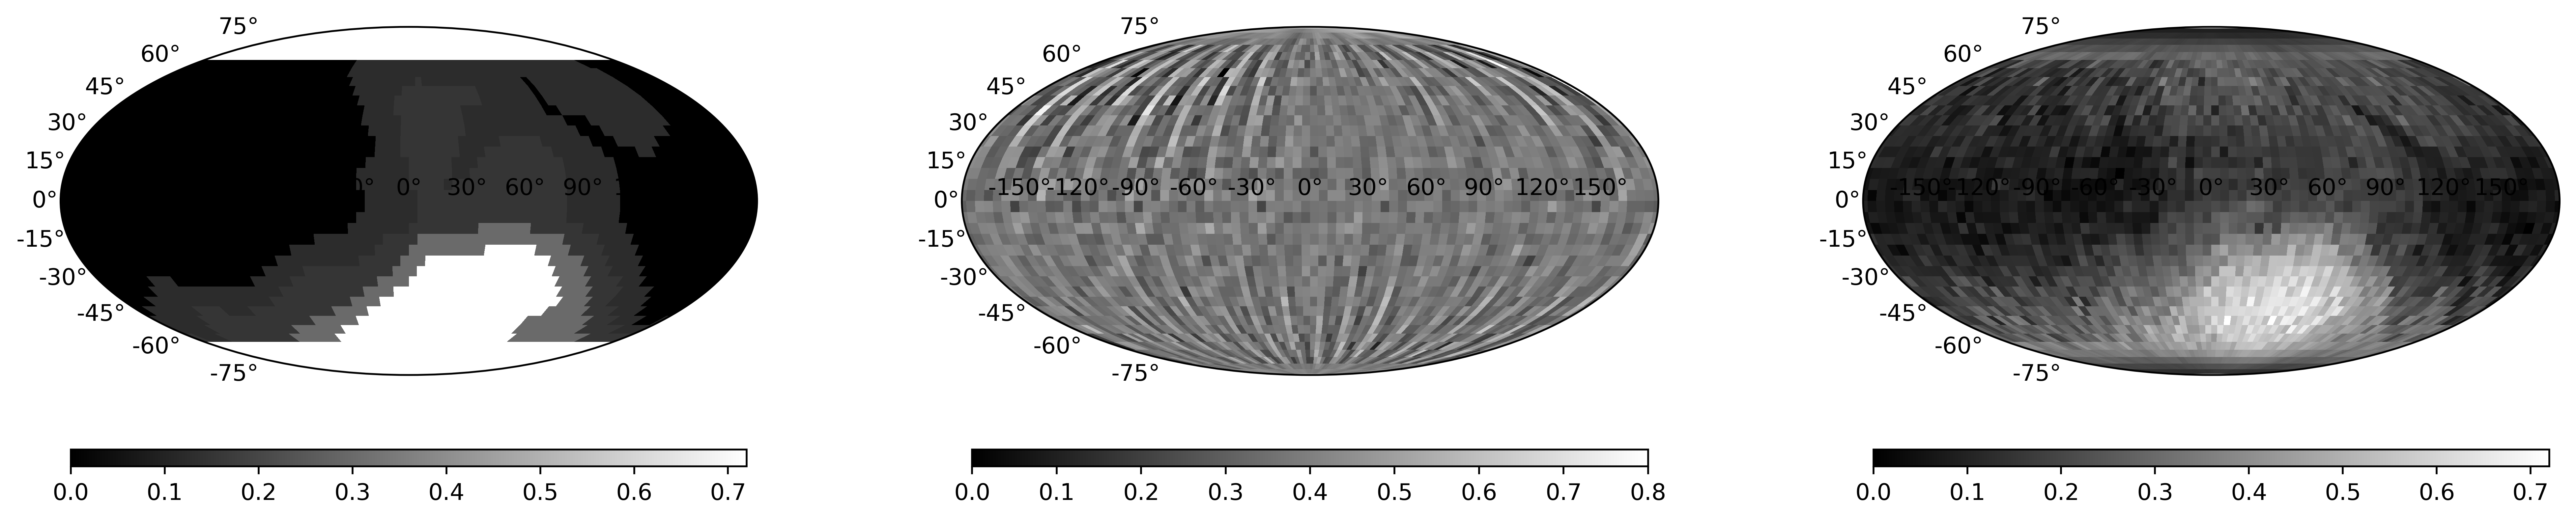

In [50]:
# detailed view of the Lambertian maps

shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
                                                                           
plt.show()

In [ ]:
Zeros = np.zeros(2*res*res)
reconstruct_Zeros = Zeros.reshape((res,2*res),order = 'F')


shrink = 0.5
lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,10), dpi = 800)
ax1 = fig1.add_subplot(331, projection = 'mollweide')
ax2 = fig1.add_subplot(332, projection = 'mollweide')
ax3 = fig1.add_subplot(333, projection = 'mollweide')
ax4 = fig1.add_subplot(334, projection = 'mollweide')
ax5 = fig1.add_subplot(335, projection = 'mollweide')
ax6 = fig1.add_subplot(336, projection = 'mollweide')
ax7 = fig1.add_subplot(337, projection = 'mollweide')
ax8 = fig1.add_subplot(338, projection = 'mollweide')
ax9 = fig1.add_subplot(339, projection = 'mollweide')


## Real maps showcase

im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealglint),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(reconstruct_Arealseel),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

##Simple model retrieval

im4 = ax4.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im4,shrink = shrink, aspect=40, ax = ax4,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

im5 = ax5.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = 'gray')
plt.colorbar(im5,shrink = shrink, aspect=40, ax = ax5,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

im6 = ax6.pcolormesh(Lon,Lat, np.flipud(reconstruct_Zeros),cmap = 'gray')
plt.colorbar(im6,shrink = shrink, aspect=40, ax = ax6,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

##complex model retrieval
im7 = ax7.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im7,shrink = shrink, aspect=40, ax = ax7,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

im8 = ax8.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompglint),cmap = 'gray')
plt.colorbar(im8,shrink = shrink, aspect=40, ax = ax8,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']

im9 = ax9.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acompseel),cmap = 'gray')
plt.colorbar(im9,shrink = shrink, aspect=40, ax = ax9,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']



plt.show()

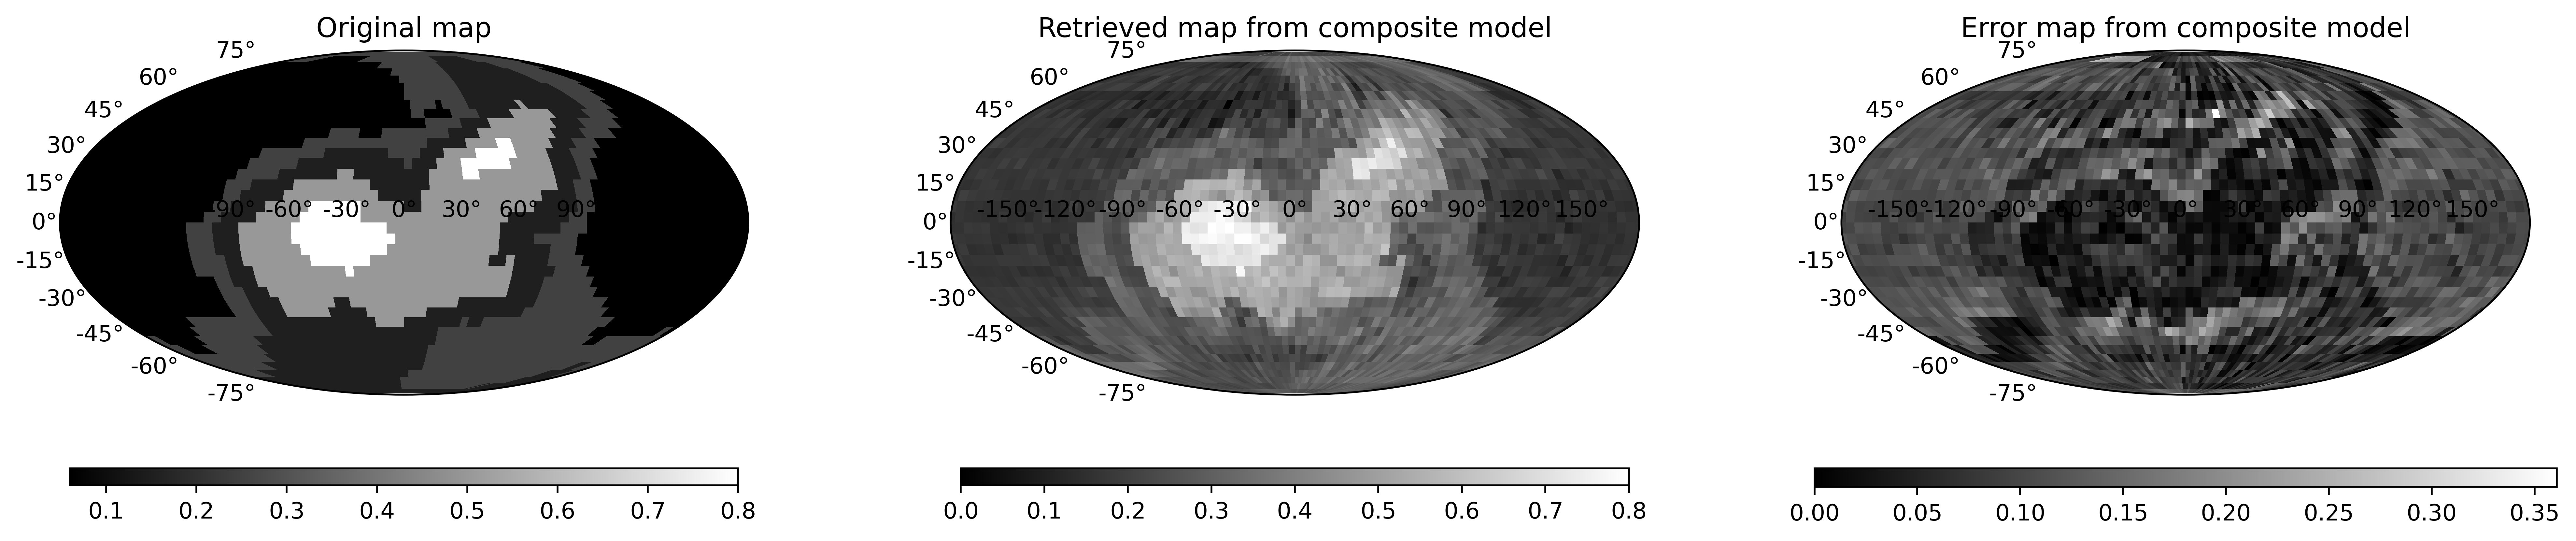

In [62]:
complamberror = np.abs(reconstruct_Areallamb - reconstruct_Acomplamb)
simplelamberror = np.abs(reconstruct_Areallamb - reconstruct_Aonlylamb)

shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('Original map')
ax2.title.set_text('Retrieved map from composite model')
ax3.title.set_text('Error map from composite model')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Aonlylamb),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(simplelamberror),cmap = 'gray')
plt.colorbar(im3,shrink = 1, aspect=40, ax = ax3,orientation = 'horizontal')
                                                                           
plt.show()

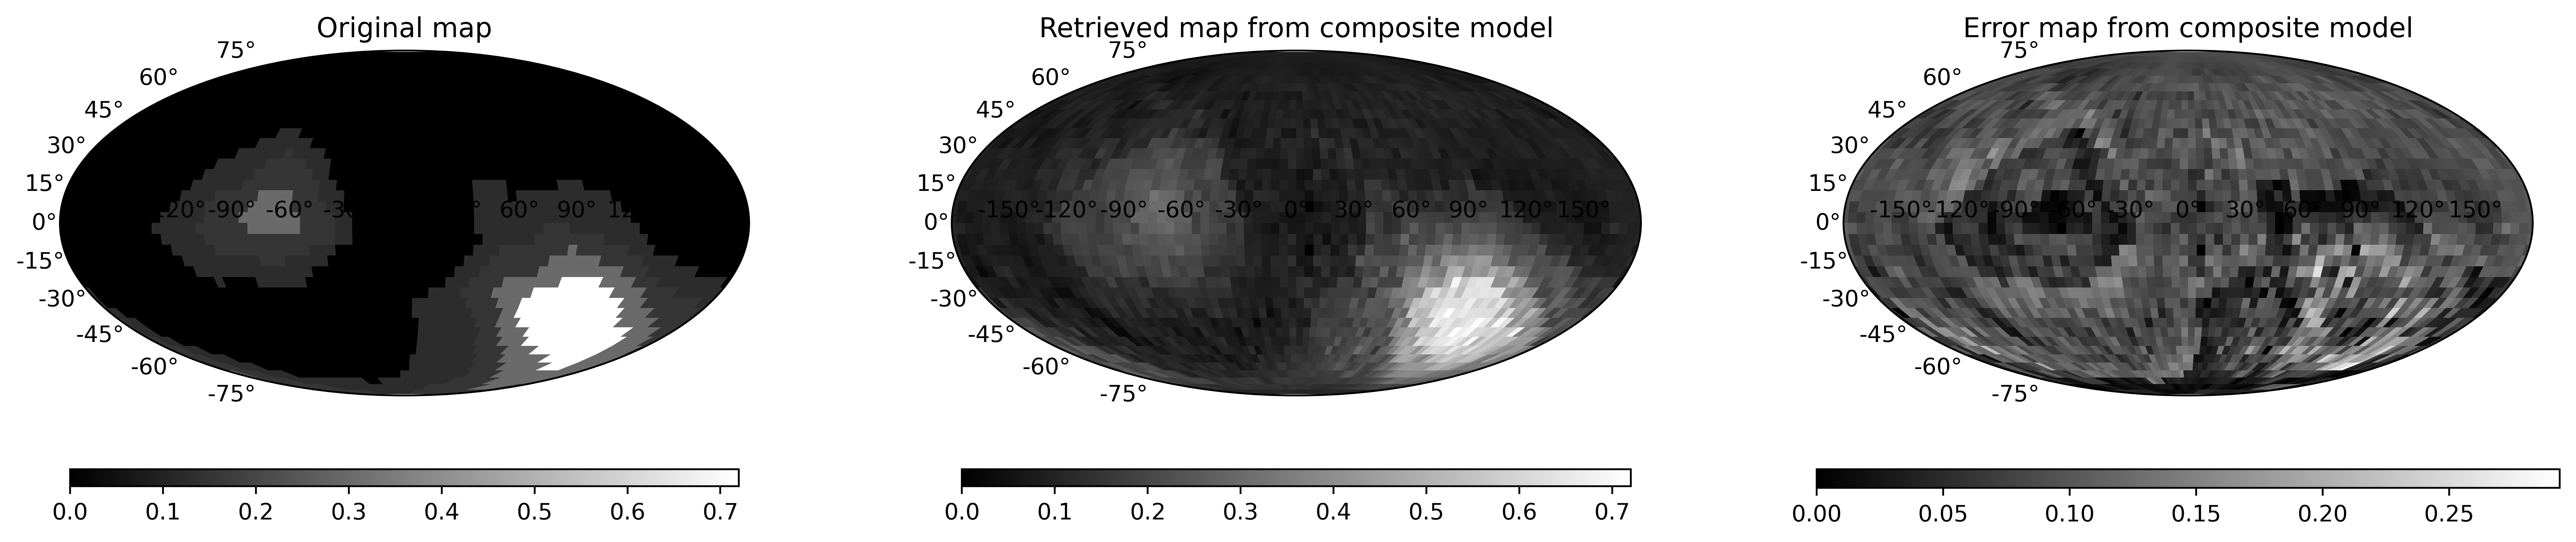

In [14]:
complamberror = np.abs(reconstruct_Areallamb - reconstruct_Acomplamb)
simplelamberror = np.abs(reconstruct_Areallamb - reconstruct_Aonlylamb)

shrink = 0.9

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 500)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('Original map')
ax2.title.set_text('Retrieved map from composite model')
ax3.title.set_text('Error map from composite model')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(reconstruct_Areallamb),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


im2 = ax2.pcolormesh(Lon,Lat, np.flipud(reconstruct_Acomplamb),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(complamberror),cmap = 'gray')
plt.colorbar(im3,shrink = 1, aspect=40, ax = ax3,orientation = 'horizontal')
                                                                           
plt.show()